# Federated Learning com Flower + DLG Attack

Este notebook implementa:
1. Federated Learning usando Flower
2. Ataque DLG (Deep Leakage from Gradients) para demonstrar vulnerabilidades de privacidade

## Instalação de Dependências

In [1]:
# --- Colar esta célula como a PRIMEIRA no notebook ---

import os
# Opcional: se você NÃO pretende usar TensorFlow aqui, NÃO importe tf (melhor evitar conflito com PyTorch)
# Se por algum motivo precisar importar TF, descomente as 2 linhas abaixo para suprimir logs e evitar prints.
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # suprime INFO/WARNING do TF (0=all, 3=ERROR only)
# os.environ["CUDA_VISIBLE_DEVICES"] = ""  # se quiser FORÇAR TF a não ver GPUs (cuidado: também afeta PyTorch)

import sys
# garante que módulos locais sob /mnt/data (utils.py, flwr_datasets, etc.) sejam encontrados
sys.path.append(".")
# também opcional: adicionar o diretório do notebook (caso esteja rodando a partir de outro cwd)
sys.path.append(os.getcwd())

# Agora faça os imports de bibliotecas e módulos (após sys.path.append)
import flwr as fl
import numpy as np

# IMPORTS DO FLWR DATASETS (se é um módulo local, agora será encontrado)
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner, DirichletPartitioner

# Imports do Flower para servidor
from flwr.common import parameters_to_ndarrays, ndarrays_to_parameters
from flwr.common import FitIns, EvaluateIns
from flwr.server.strategy.aggregate import aggregate

# Torch (deixe por último, depois de tratar env vars se necessário)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# IMPORTS LOCAIS
import utils  # importar o módulo inteiro (import utils é necessário para referências utils.foo em atores remotos)

# Opcional: atalhos (mantém nomes no namespace)
from utils import (
    cria_dataset,
    weights_init,
    label_to_onehot,
    get_imagem_e_label,
    cria_ruido,
    mostra_imagem,
    cross_entropy_for_onehot,
    compara_imagens
)

print("Imports OK — utils carregado corretamente.")
print("✓ Imports completos")


2025-11-25 16:41:02.061120: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-25 16:41:02.061721: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-25 16:41:02.063533: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-25 16:41:02.069454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-25 16:41:02.080963: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

Usando o dispositivo: cuda
Imports OK — utils carregado corretamente.
✓ Imports completos


## Código Cliente

In [2]:
# ----------------------------
# Bloco 2 — Classe do Cliente 
# ----------------------------

import torch

class GradientQuantizer:
    def __init__(self, num_bits=8):
        self.num_bits = num_bits
        self.num_levels = 2 ** num_bits

    def quantize_gradients(self, gradients):
        """Quantização com escala GLOBAL."""
        quantized_grads = []

        # Flatten de todos para achar min/max global
        all_values = torch.cat([
            g.flatten() for g in gradients 
            if g is not None
        ])

        global_min = all_values.min().item()
        global_max = all_values.max().item()

        scale = (global_max - global_min) / (self.num_levels - 1)
        if scale == 0:
            scale = 1.0

        for g in gradients:
            if g is None:
                quantized_grads.append(None)
                continue

            q = torch.round((g - global_min) / scale)
            q = torch.clamp(q, 0, self.num_levels - 1)

            dtype = torch.uint8 if self.num_bits <= 8 else torch.int16
            quantized_grads.append(q.to(dtype))

        metadata = {
            "min": global_min,
            "max": global_max,
            "num_bits": self.num_bits,
        }

        return quantized_grads, metadata

    def dequantize_gradients(self, quantized_grads, metadata):
        """Reconstrói gradientes usando min/max global."""
        dequantized = []

        global_min = metadata["min"]
        global_max = metadata["max"]
        scale = (global_max - global_min) / (self.num_levels - 1)

        for q in quantized_grads:
            if q is None:
                dequantized.append(None)
                continue

            dq = q.float() * scale + global_min
            dequantized.append(dq)

        return dequantized

    def aggregate_quantized(self, quantized_grads_list, weights_list):
        """Agregação dos gradientes quantizados."""
        if not quantized_grads_list:
            return []

        total_weight = sum(weights_list)
        num_params = len(quantized_grads_list[0])
        aggregated = []

        for idx in range(num_params):
            weighted_sum = None

            for client_grads, weight in zip(quantized_grads_list, weights_list):
                if idx >= len(client_grads):
                    continue

                g = client_grads[idx]
                if g is None:
                    continue

                g_float = g.float() * (weight / total_weight)

                if weighted_sum is None:
                    weighted_sum = g_float
                else:
                    weighted_sum += g_float

            if weighted_sum is not None:
                q = torch.round(weighted_sum)
                dtype = torch.uint8 if self.num_bits <= 8 else torch.int16
                aggregated.append(q.clamp(0, self.num_levels - 1).to(dtype))
            else:
                aggregated.append(None)

        return aggregated

    def compress_ratio(self):
        """Retorna taxa de compressão teórica."""
        return 32 / self.num_bits


In [3]:
# Bloco corrigido: ClienteComQuantizacao
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch
import torch.nn as nn
import torch.optim as optim
import gc

import utils  # garante o uso do utils.cria_dataset/cria_modelo

class ClienteComQuantizacao(fl.client.NumPyClient):
    def __init__(
        self,
        cid,
        niid,
        num_clients,
        dirichlet_alpha,
        quantizer=None,
        dataset_path="/home/nicolas/Documentos/topicos_sistemas_distribuidos/trabalho/DATASETS/Pokedex_v14"
    ):
        self.cid = int(cid)
        self.niid = niid
        self.num_clients = num_clients
        self.dirichlet_alpha = dirichlet_alpha
        self.quantizer = quantizer
        self.dataset_path = dataset_path

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"[Cliente {self.cid}] Device: {self.device}")

        # Carregar dataset completo com o transform correto (do utils)
        # utils.cria_dataset retorna (dataset, transform)
        full_dataset, self.transform = utils.cria_dataset("pokemon", dataset_path=self.dataset_path)

        # Particionar localmente para este cliente
        self.full_dataset = full_dataset  # guardamos para create_model e debugging
        self.train_dataset, self.test_dataset = self.load_data()

        # Criar modelo usando o dataset (garante num_classes correto)
        self.model = self.create_model()
        self.model.to(self.device)

        try:
            self.num_train_samples = len(self.train_dataset)
            self.num_test_samples = len(self.test_dataset)
        except Exception:
            self.num_train_samples = 0
            self.num_test_samples = 0

    # -------------------------
    # utilitarios de parametros
    # -------------------------
    def get_parameters(self, config):
        # Retorna lista de ndarrays (mesma ordem keys() do state_dict)
        return [val.cpu().numpy() for val in self.model.state_dict().values()]

    def set_parameters(self, parameters, config):
        # Recebe lista de ndarrays; monta state_dict preservando a ordem das chaves
        keys = list(self.model.state_dict().keys())
        if len(keys) != len(parameters):
            raise ValueError(f"[Cliente {self.cid}] Número de parâmetros recebidos ({len(parameters)}) != esperado ({len(keys)})")
        state_dict = {k: torch.tensor(v, dtype=torch.float32) for k, v in zip(keys, parameters)}
        self.model.load_state_dict(state_dict, strict=True)

    # -------------------------
    # dados locais (sem GLOBAL_DATASET)
    # -------------------------
    def load_data(self):
        """
        Cria partição local do full_dataset (carregado via utils.cria_dataset).
        Retorna (train_subset, test_subset) como torch Subset/SubsetRandomSplit.
        """
        # full_dataset já salvo em self.full_dataset no __init__
        num_samples = len(self.full_dataset)
        indices = np.arange(num_samples)
        np.random.seed(42)
        np.random.shuffle(indices)

        if self.niid:
            # Distribuição NIID — usa 'dirichlet' style: simplificado com split igual aqui
            # Se quiser a partição Dirichlet real, trocamos aqui.
            split = np.array_split(indices, self.num_clients)
            client_indices = split[self.cid]
        else:
            # IID: fatia intercalada
            client_indices = indices[self.cid::self.num_clients]

        # Criar subset para o cliente
        client_subset = Subset(self.full_dataset, client_indices)

        # Dividir em train/test 80/20 (local)
        train_size = int(len(client_subset) * 0.8)
        test_size = len(client_subset) - train_size
        if train_size == 0:
            # fallback mínimo
            return client_subset, client_subset

        train_subset, test_subset = torch.utils.data.random_split(
            client_subset, [train_size, test_size], generator=torch.Generator().manual_seed(42)
        )

        return train_subset, test_subset

    # -------------------------
    # criar modelo com utils (garante compatibilidade)
    # -------------------------
    def create_model(self):
        # Usa o full_dataset (ImageFolder com transform) para descobrir num_classes
        return utils.cria_modelo("pokemon", dataset=self.full_dataset)

    # -------------------------
    # fit: tuneado conforme tua lógica
    # -------------------------
    def fit(self, parameters, config):
        try:
            server_round = config.get('server_round', 0)
            print(f"\n[Cliente {self.cid}] FIT RODADA {server_round}")

            # 1) sincronizar pesos
            self.set_parameters(parameters, config)

            # salvar pesos iniciais
            initial_weights = [p.data.clone().cpu() for p in self.model.parameters()]

            self.model.train()

            IS_ATTACK_ROUND = (server_round == 1)

            if IS_ATTACK_ROUND:
                local_epochs = 1
                batch_size = 1
                lr = 0.01
                optim_type = 'sgd'
                label_smoothing = 0.0
                use_clipping = False
                shuffle_data = False
            else:
                local_epochs = 15
                batch_size = 64
                lr = 0.002
                optim_type = 'adam'
                label_smoothing = 0.1
                use_clipping = True
                shuffle_data = True

            train_loader = DataLoader(
                self.train_dataset,
                batch_size=batch_size,
                shuffle=shuffle_data,
                num_workers=2,
                pin_memory=True if self.device.type == 'cuda' else False
            )

            if optim_type == 'adam':
                optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-4)
            else:
                optimizer = optim.SGD(self.model.parameters(), lr=lr)

            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
            criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

            first_image_gradient = None
            first_image_captured = False

            total_samples = 0
            total_correct = 0
            running_loss = 0.0
            stop_training = False

            for epoch in range(local_epochs):
                if stop_training:
                    break

                epoch_samples = 0
                epoch_correct = 0
                epoch_loss = 0.0

                for i, (images, labels) in enumerate(train_loader):
                    images, labels = images.to(self.device), labels.to(self.device)

                    if not first_image_captured:
                        self.model.zero_grad()
                        single_output = self.model(images[0:1])
                        single_loss = criterion(single_output, labels[0:1])
                        single_loss.backward()

                        # guarde gradientes (lista de tensores CPU)
                        first_image_gradient = [
                            (p.grad.detach().clone().cpu() if p.grad is not None else torch.zeros_like(p.data).cpu())
                            for p in self.model.parameters()
                        ]
                        first_image_captured = True
                        print(f"[Cliente {self.cid}] Gradientes capturados! Label: {labels[0].item()}")

                    # treinamento normal
                    optimizer.zero_grad()
                    outputs = self.model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()

                    if use_clipping:
                        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

                    optimizer.step()

                    _, predicted = outputs.max(1)
                    batch_correct = predicted.eq(labels).sum().item()
                    batch_samples = labels.size(0)

                    epoch_samples += batch_samples
                    epoch_correct += batch_correct
                    epoch_loss += loss.item() * batch_samples

                    if IS_ATTACK_ROUND:
                        # interrompe após 1 batch (FedSGD)
                        stop_training = True
                        break

                if not stop_training:
                    scheduler.step()

                total_samples += epoch_samples
                total_correct += epoch_correct
                running_loss += epoch_loss

            avg_loss = running_loss / total_samples if total_samples > 0 else 0.0
            avg_acc = total_correct / total_samples if total_samples > 0 else 0.0

            current_weights = [p.data.cpu() for p in self.model.parameters()]

            if first_image_gradient is None:
                first_image_gradient = [torch.zeros_like(p).cpu() for p in self.model.parameters()]

            print(f"[Cliente {self.cid}] Fim Fit - Loss: {avg_loss:.4f}, Acc: {avg_acc:.4f}")

            # Preparar retorno (quantizado ou não)
            if self.quantizer is not None:
                quantized_weights, weight_metadata = self.quantizer.quantize_gradients(current_weights)
                quantized_initial, initial_metadata = self.quantizer.quantize_gradients(initial_weights)
                quantized_grads, grad_metadata = self.quantizer.quantize_gradients(first_image_gradient)

                params_to_send = [w.cpu().numpy() if w is not None else None for w in quantized_weights]
                initial_to_send = [w.cpu().numpy() if w is not None else None for w in quantized_initial]
                grads_to_send = [g.cpu().numpy() if g is not None else None for g in quantized_grads]

                fit_msg = {
                    'cid': self.cid, 'accuracy': float(avg_acc), 'loss': float(avg_loss),
                    'quantized': True,
                    'quant_min': float(weight_metadata['min']), 'quant_max': float(weight_metadata['max']),
                    'quant_bits': int(weight_metadata['num_bits']),
                    'initial_quant_min': float(initial_metadata['min']), 'initial_quant_max': float(initial_metadata['max']),
                    'grad_quant_min': float(grad_metadata['min']), 'grad_quant_max': float(grad_metadata['max']),
                    'num_weights': len(params_to_send), 'num_initial': len(initial_to_send),
                }
            else:
                params_to_send = [w.numpy() if w is not None else None for w in current_weights]
                initial_to_send = [w.numpy() if w is not None else None for w in initial_weights]
                grads_to_send = [g.numpy() if g is not None else None for g in first_image_gradient]

                fit_msg = {
                    'cid': self.cid, 'accuracy': float(avg_acc), 'loss': float(avg_loss),
                    'quantized': False,
                    'num_weights': len(params_to_send), 'num_initial': len(initial_to_send),
                }

            combined_params = params_to_send + initial_to_send + grads_to_send

            self.log_client('train.csv', server_round, avg_acc, avg_loss)
            print(f"[Cliente {self.cid}] Retornando {len(combined_params)} parâmetros")

            # cleanup
            del train_loader, optimizer, loss
            torch.cuda.empty_cache()
            gc.collect()

            return combined_params, int(self.num_train_samples), fit_msg

        except Exception as e:
            print(f"❌ CRASH CLIENTE {self.cid}: {type(e).__name__}: {e}")
            import traceback
            traceback.print_exc()
            raise

    # -------------------------
    # evaluate (único)
    # -------------------------
    def evaluate(self, parameters, config):
        self.set_parameters(parameters, config)
        self.model.eval()

        test_loader = DataLoader(
            self.test_dataset,
            batch_size=128,
            shuffle=False,
            num_workers=0,
            pin_memory=False
        )

        criterion = nn.CrossEntropyLoss()

        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        avg_loss = test_loss / len(test_loader) if len(test_loader) > 0 else 0.0
        accuracy = correct / total if total > 0 else 0.0

        eval_msg = {
            'cid': self.cid,
            'accuracy': accuracy,
            'loss': avg_loss
        }

        self.log_client('evaluate.csv', config.get('server_round', -1), accuracy, avg_loss)
        return avg_loss, int(self.num_test_samples), eval_msg

    # -------------------------
    # logging simples
    # -------------------------
    def log_client(self, file_name, server_round, acc, loss):
        try:
            with open(file_name, 'a') as file:
                file.write(f'{server_round}, {self.cid}, {acc}, {loss}\n')
        except Exception:
            pass


## Código Servidor

In [ ]:
# ===== Globals para captura e acesso fora do worker (Notebook)
GLOBAL_GRADS = {}        # chave: (rodada, cid) -> lista de gradientes (numpy/torch)
GLOBAL_WEIGHTS = {}      # chave: (rodada, cid) -> pesos finais
GLOBAL_INITIALS = {}     # chave: (rodada, cid) -> pesos iniciais
GLOBAL_METADATA = {}     # chave: (rodada, cid) -> metadata (min/max/num_bits)

# OPTIONAL: local disk dump for persistence (descomente se quiser)
# import pickle, os
# PERSIST_DIR = "/tmp/fl_captures"
# os.makedirs(PERSIST_DIR, exist_ok=True)

class ServidorComQuantizacao(fl.server.strategy.FedAvg):
    def __init__(self, num_clients, dirichlet_alpha, fraction_fit=0.5, quantizer=None):
        super().__init__(
            fraction_fit=fraction_fit,
            min_available_clients=num_clients
        )

        self.num_clients = num_clients
        self.dirichlet_alpha = dirichlet_alpha
        self.quantizer = quantizer

        # Mantemos como opcional/local (não usados para comunicação com notebook)
        self.intercepted_gradients = {}
        self.intercepted_weights = {}
        self.intercepted_initials = {}

        self.metadata_grad = {}
        self.metadata_weights = {}
        self.metadata_initial = {}

        self.global_quantized_weights = None
        self.global_metadata = None

    def configure_fit(self, server_round, parameters, client_manager):
        config = {"server_round": server_round}
        if self.global_metadata is not None and server_round > 1:
            config.update({
                "quant_min": float(self.global_metadata["min"]),
                "quant_max": float(self.global_metadata["max"]),
                "quant_bits": int(self.global_metadata["num_bits"])
            })

        fit_ins = FitIns(parameters, config)
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        return [(c, fit_ins) for c in clients]

    def aggregate_fit(self, server_round, results, failures):
        print(f"\n=== [Servidor] Rodada {server_round} ===")

        if not results:
            print("Nenhum resultado recebido")
            return None, {}

        quantized_groups = []
        num_examples_list = []
        metadata_list = []

        for client, fit_res in results:
            cid = fit_res.metrics["cid"]
            acc = fit_res.metrics["accuracy"]
            loss = fit_res.metrics["loss"]
            is_quant = fit_res.metrics.get("quantized", False)

            print(f"[Cliente {cid}] acc={acc:.4f} loss={loss:.4f} quant={is_quant}")

            params = parameters_to_ndarrays(fit_res.parameters)
            num_weights = fit_res.metrics["num_weights"]
            num_initial = fit_res.metrics["num_initial"]

            # Separação enviada pelo cliente
            w_final = params[:num_weights]
            w_init  = params[num_weights:num_weights+num_initial]
            grads   = params[num_weights+num_initial:]

            # --- SALVA NAS ESTRUTURAS LOCAIS (opcional) ---
            self.intercepted_weights[(server_round, cid)] = w_final
            self.intercepted_initials[(server_round, cid)] = w_init
            self.intercepted_gradients[(server_round, cid)] = grads

            # --- SALVA NOS GLOBAIS VISÍVEIS AO NOTEBOOK ---
            GLOBAL_WEIGHTS[(server_round, cid)] = w_final
            GLOBAL_INITIALS[(server_round, cid)] = w_init
            GLOBAL_GRADS[(server_round, cid)] = grads

            # metadata (se existir)
            if is_quant:
                w_meta = {
                    "min": fit_res.metrics["quant_min"],
                    "max": fit_res.metrics["quant_max"],
                    "num_bits": fit_res.metrics["quant_bits"]
                }
            else:
                w_meta = None

            self.metadata_weights[(server_round, cid)] = w_meta
            GLOBAL_METADATA[(server_round, cid)] = w_meta

            num_examples = int(fit_res.num_examples)
            num_examples_list.append(num_examples)

            if is_quant:
                metadata_list.append(w_meta)
                # Converter de numpy -> torch (se precisar agregar como tensores)
                w_final_t = [torch.from_numpy(x) if x is not None else None for x in w_final]
                quantized_groups.append(w_final_t)
            else:
                metadata_list.append(None)
                w_final_np = [np.array(x) for x in w_final]
                quantized_groups.append(w_final_np)

            # OPTIONAL: persistir imediatamente em disco (descomente para ativar)
            # fname = os.path.join(PERSIST_DIR, f"round{server_round}_client{cid}.pkl")
            # with open(fname, "wb") as fh:
            #     pickle.dump({"weights": w_final, "initial": w_init, "grads": grads, "meta": w_meta}, fh)

        # =====================================================
        # AGREGAÇÃO
        # =====================================================
        if self.quantizer is not None and any(m is not None for m in metadata_list):
            print("[Servidor] Agregando pesos QUANTIZADOS")
            agg_tensors = self.quantizer.aggregate_quantized(quantized_groups, num_examples_list)
            self.global_metadata = metadata_list[0]
            agg_numpy = [t.cpu().numpy() if t is not None else None for t in agg_tensors]
        else:
            print("[Servidor] Agregando pesos NÃO quantizados")
            agg_numpy = []
            num_layers = len(quantized_groups[0])
            total_w = sum(num_examples_list)
            for layer_idx in range(num_layers):
                acc_layer = None
                for client_layer, n in zip(quantized_groups, num_examples_list):
                    val = client_layer[layer_idx]
                    if val is None:
                        continue
                    contrib = val * (n / total_w)
                    acc_layer = contrib if acc_layer is None else acc_layer + contrib
                agg_numpy.append(acc_layer)

        new_params = ndarrays_to_parameters(agg_numpy)
        return new_params, {}

    def configure_evaluate(self, server_round, parameters, client_manager):
        config = {"server_round": server_round}
        if self.global_metadata is not None and server_round > 1:
            config.update({
                "quant_min": float(self.global_metadata["min"]),
                "quant_max": float(self.global_metadata["max"]),
                "quant_bits": int(self.global_metadata["num_bits"])
            })

        evaluate_ins = EvaluateIns(parameters, config)
        sample_size, min_num_clients = self.num_evaluation_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        return [(c, evaluate_ins) for c in clients]

    def aggregate_evaluate(self, server_round, results, failures):
        if not results:
            print("[Servidor] Nenhum cliente avaliou")
            return 0.0, {}
        accs = [res.metrics["accuracy"] for _, res in results]
        mean_acc = sum(accs) / len(accs)
        print(f"[Servidor] Acurácia agregada na rodada {server_round}: {mean_acc:.4f}")
        return mean_acc, {}


## Configuração da Simulação

In [5]:
import sys, os
import warnings
import logging

# ====================================================
# FAZER O PYTHON ENXERGAR utils.py, run.py, load.py
# ====================================================
# Em notebook: SEMPRE usar o diretório do dataset / código
project_root = "."   # <-- ONDE ESTÃO utils.py, load.py, run.py

if project_root not in sys.path:
    sys.path.append(project_root)

print("✓ sys.path configurado — utils.py disponível")

# ====================================================
# RAY — CONFIGURAÇÃO CORRETA PARA NOTEBOOK
# ====================================================
import ray

# Evita conflitos de execução
try:
    ray.shutdown()
except:
    pass

# No notebook NÃO usar working_dir=os.getcwd() (quebra paths)
ray.init(
    ignore_reinit_error=True,
    include_dashboard=False,
    _system_config={"automatic_object_spilling_enabled": True}
)

print("✓ Ray inicializado no modo Notebook")

# ====================================================
# SUPRIMIR WARNINGS
# ====================================================
warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.ERROR)

# ==============================================
# CONFIGURAÇÃO GERAL
# ==============================================
NCLIENTS        = 5
NROUNDS         = 10
NIID            = False
DIRICHLET_ALPHA = 0.1
FRACTION_FIT    = 1.0

# ==============================================
# QUANTIZAÇÃO
# ==============================================
ENABLE_QUANTIZATION = False
QUANT_BITS = 8

if ENABLE_QUANTIZATION:
    quantizer = GradientQuantizer(QUANT_BITS)
    print(f"✓ Quantização ativa ({QUANT_BITS} bits)")
else:
    quantizer = None
    print("✓ Sem quantização (baseline)")

# ==============================================
# CLIENTES
# ==============================================
def create_client(cid: str):
    """Construtor de clientes compatível com Flower Simulation"""
    client = ClienteComQuantizacao(
        cid              = int(cid),
        niid             = NIID,
        num_clients      = NCLIENTS,
        dirichlet_alpha  = DIRICHLET_ALPHA,
        quantizer        = quantizer,
    )
    return client.to_client()


# ==============================================
# SIMULAÇÃO
# ==============================================
ray_init_args = {
    "runtime_env": {
        "working_dir": "."
    }
}


class Simulation:
    def __init__(self):
        self.strategy = ServidorComQuantizacao(
            num_clients     = NCLIENTS,
            dirichlet_alpha = DIRICHLET_ALPHA,
            fraction_fit    = FRACTION_FIT,
            quantizer       = quantizer,
        )

    def run(self):
        fl.simulation.start_simulation(
            client_fn     = create_client,
            num_clients   = NCLIENTS,
            client_resources={"num_cpus": 1},
            config        = fl.server.ServerConfig(num_rounds=NROUNDS),
            strategy      = self.strategy,    # <<-- USE ELA
            ray_init_args = ray_init_args,
        )
        return self.strategy


# ==============================================
# EXECUÇÃO
# ==============================================
print("\n==============================")
print("Iniciando simulação FL")
print("==============================\n")

servidor = None

try:
    sim = Simulation()
    servidor = sim.run()
    print("\n✔ Simulação concluída com sucesso!")

except Exception as e:
    print("\n❌ SIMULAÇÃO CRASHOU")
    print(f"Erro: {type(e).__name__}: {str(e)}")

    import traceback
    traceback.print_exc()

    if sim and hasattr(sim, "server"):
        servidor = sim.server
        print("\nDados capturados (parciais):")
        # Corrigido: intercepted_gradients é o nome correto
        print(f"- Gradientes capturados: {len(servidor.intercepted_gradients)}")

finally:
    print("\n==============================")
    if servidor:
        print(f"Gradientes disponíveis: {len(servidor.intercepted_gradients)}")
        if servidor.intercepted_gradients:
            print("Exemplo de chaves:")
            print(list(servidor.intercepted_gradients.keys())[:5])
    else:
        print("⚠ Nada foi capturado")


✓ sys.path configurado — utils.py disponível


2025-11-25 16:41:10,643	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout


✓ Ray inicializado no modo Notebook
✓ Sem quantização (baseline)

Iniciando simulação FL



2025-11-25 16:41:18,109	INFO worker.py:1752 -- Started a local Ray instance.
2025-11-25 16:41:18,115	INFO packaging.py:530 -- Creating a file package for local directory '.'.
2025-11-25 16:41:18,116	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_0784d103fb0d9b54.zip' (0.09MiB) to Ray cluster...
2025-11-25 16:41:18,118	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_0784d103fb0d9b54.zip'.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 20.0, 'node:100.112.10.31': 1.0, 'GPU': 1.0, 'accelerator_type:G': 1.0, 'node:__internal_head__': 1.0, 'memory': 7743614976.0, 'object_store_memory': 3871807488.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 20 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one ran

(ClientAppActor pid=33179) Usando o dispositivo: cpu
(ClientAppActor pid=33179) [Cliente 3] Device: cpu
(ClientAppActor pid=33179) [Cliente 0] Device: cpu
(ClientAppActor pid=33179) 
(ClientAppActor pid=33179) [Cliente 0] FIT RODADA 1
(ClientAppActor pid=33179) [Cliente 0] Gradientes capturados! Label: 0
(ClientAppActor pid=33179) [Cliente 0] Fim Fit - Loss: 11.3144, Acc: 0.0000
(ClientAppActor pid=33179) [Cliente 0] Retornando 30 parâmetros


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)



=== [Servidor] Rodada 1 ===
[Cliente 0] acc=0.0000 loss=11.3144 quant=False
[Cliente 2] acc=0.0000 loss=11.1003 quant=False
[Cliente 3] acc=0.0000 loss=16.3957 quant=False
[Cliente 4] acc=0.0000 loss=2.0226 quant=False
[Cliente 1] acc=0.0000 loss=36.7596 quant=False
[Servidor] Agregando pesos NÃO quantizados


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Servidor] Acurácia agregada na rodada 1: 0.4139
(ClientAppActor pid=33176) Usando o dispositivo: cpu [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(ClientAppActor pid=33177) [Cliente 4] Device: cpu [repeated 14x across cluster]
(ClientAppActor pid=33177)  [repeated 9x across cluster]
(ClientAppActor pid=33177) [Cliente 4] FIT RODADA 2 [repeated 9x across cluster]
(ClientAppActor pid=33177) [Cliente 4] Gradientes capturados! Label: 2 [repeated 9x across cluster]
(ClientAppActor pid=33175) [Cliente 1] Fim Fit - Loss: 1.5707, Acc: 0.4379 [repeated 5x across cluster]
(ClientAppActor pid=33175) [Cliente 1] Retornando 30 parâmetros [repeated 5x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)



=== [Servidor] Rodada 2 ===
[Cliente 4] acc=0.4262 loss=1.5833 quant=False
[Cliente 1] acc=0.4379 loss=1.5707 quant=False
[Cliente 2] acc=0.4217 loss=1.5861 quant=False
[Cliente 3] acc=0.4258 loss=1.5881 quant=False
[Cliente 0] acc=0.4439 loss=1.5232 quant=False
[Servidor] Agregando pesos NÃO quantizados


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Servidor] Acurácia agregada na rodada 2: 0.2792
(ClientAppActor pid=33176) [Cliente 2] Device: cpu [repeated 10x across cluster]
(ClientAppActor pid=33177)  [repeated 5x across cluster]
(ClientAppActor pid=33177) [Cliente 4] FIT RODADA 3 [repeated 5x across cluster]
(ClientAppActor pid=33179) [Cliente 1] Gradientes capturados! Label: 0 [repeated 5x across cluster]
(ClientAppActor pid=33178) [Cliente 3] Fim Fit - Loss: 1.4063, Acc: 0.4100 [repeated 5x across cluster]
(ClientAppActor pid=33178) [Cliente 3] Retornando 30 parâmetros [repeated 5x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)



=== [Servidor] Rodada 3 ===
[Cliente 4] acc=0.4234 loss=1.4085 quant=False
[Cliente 1] acc=0.4304 loss=1.3183 quant=False
[Cliente 2] acc=0.4242 loss=1.3982 quant=False
[Cliente 0] acc=0.4457 loss=1.3624 quant=False
[Cliente 3] acc=0.4100 loss=1.4063 quant=False
[Servidor] Agregando pesos NÃO quantizados


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Servidor] Acurácia agregada na rodada 3: 0.3891
(ClientAppActor pid=33176) [Cliente 4] Device: cpu [repeated 10x across cluster]
(ClientAppActor pid=33175)  [repeated 5x across cluster]
(ClientAppActor pid=33175) [Cliente 0] FIT RODADA 4 [repeated 5x across cluster]
(ClientAppActor pid=33177) [Cliente 2] Gradientes capturados! Label: 3 [repeated 5x across cluster]
(ClientAppActor pid=33178) [Cliente 1] Fim Fit - Loss: 1.3435, Acc: 0.4174 [repeated 5x across cluster]
(ClientAppActor pid=33178) [Cliente 1] Retornando 30 parâmetros [repeated 5x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)



=== [Servidor] Rodada 4 ===
[Cliente 4] acc=0.4111 loss=1.3601 quant=False
[Cliente 2] acc=0.4030 loss=1.3693 quant=False
[Cliente 1] acc=0.4174 loss=1.3435 quant=False
[Cliente 0] acc=0.4216 loss=1.3625 quant=False
[Cliente 3] acc=0.3924 loss=1.4084 quant=False
[Servidor] Agregando pesos NÃO quantizados


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Servidor] Acurácia agregada na rodada 4: 0.4042
(ClientAppActor pid=33177) [Cliente 1] Device: cpu [repeated 10x across cluster]
(ClientAppActor pid=33177)  [repeated 5x across cluster]
(ClientAppActor pid=33177) [Cliente 1] FIT RODADA 5 [repeated 5x across cluster]
(ClientAppActor pid=33176) [Cliente 3] Gradientes capturados! Label: 3 [repeated 5x across cluster]
(ClientAppActor pid=33179) [Cliente 2] Fim Fit - Loss: 1.3220, Acc: 0.4090 [repeated 5x across cluster]
(ClientAppActor pid=33179) [Cliente 2] Retornando 30 parâmetros [repeated 5x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)



=== [Servidor] Rodada 5 ===
[Cliente 4] acc=0.4040 loss=1.3519 quant=False
[Cliente 3] acc=0.4046 loss=1.3304 quant=False
[Cliente 2] acc=0.4090 loss=1.3220 quant=False
[Cliente 1] acc=0.4145 loss=1.3308 quant=False
[Cliente 0] acc=0.4203 loss=1.3459 quant=False
[Servidor] Agregando pesos NÃO quantizados


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Servidor] Acurácia agregada na rodada 5: 0.4139
(ClientAppActor pid=33176) [Cliente 2] Device: cpu [repeated 10x across cluster]
(ClientAppActor pid=33177)  [repeated 5x across cluster]
(ClientAppActor pid=33177) [Cliente 4] FIT RODADA 6 [repeated 5x across cluster]
(ClientAppActor pid=33177) [Cliente 4] Gradientes capturados! Label: 2 [repeated 5x across cluster]
(ClientAppActor pid=33177) [Cliente 4] Fim Fit - Loss: 1.3213, Acc: 0.4171 [repeated 5x across cluster]
(ClientAppActor pid=33177) [Cliente 4] Retornando 30 parâmetros [repeated 5x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)



=== [Servidor] Rodada 6 ===
[Cliente 0] acc=0.4148 loss=1.3322 quant=False
[Cliente 3] acc=0.4006 loss=1.3880 quant=False
[Cliente 1] acc=0.4088 loss=1.3594 quant=False
[Cliente 4] acc=0.4171 loss=1.3213 quant=False
[Cliente 2] acc=0.4046 loss=1.3402 quant=False
[Servidor] Agregando pesos NÃO quantizados


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Servidor] Acurácia agregada na rodada 6: 0.3903
(ClientAppActor pid=33177) [Cliente 4] Device: cpu [repeated 10x across cluster]
(ClientAppActor pid=33175)  [repeated 5x across cluster]
(ClientAppActor pid=33175) [Cliente 2] FIT RODADA 7 [repeated 5x across cluster]
(ClientAppActor pid=33175) [Cliente 2] Gradientes capturados! Label: 2 [repeated 5x across cluster]
(ClientAppActor pid=33178) [Cliente 0] Fim Fit - Loss: 1.3354, Acc: 0.4122 [repeated 5x across cluster]
(ClientAppActor pid=33178) [Cliente 0] Retornando 30 parâmetros [repeated 5x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)



=== [Servidor] Rodada 7 ===
[Cliente 3] acc=0.4032 loss=1.3436 quant=False
[Cliente 4] acc=0.4142 loss=1.3363 quant=False
[Cliente 0] acc=0.4122 loss=1.3354 quant=False
[Cliente 2] acc=0.4090 loss=1.3321 quant=False
[Cliente 1] acc=0.4133 loss=1.3288 quant=False
[Servidor] Agregando pesos NÃO quantizados


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Servidor] Acurácia agregada na rodada 7: 0.3996


(raylet) [2025-11-25 16:46:18,098 E 32044 32044] (raylet) node_manager.cc:2967: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 5d0a60fc9ddf34f7e2e82e309ad8614ca19161fbdbad54ea7534c65a, IP: 100.112.10.31) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 100.112.10.31`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(pid=33178) 2025-11-25 16:41:26.472097: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You ma

(ClientAppActor pid=33179) [Cliente 2] Device: cpu [repeated 10x across cluster]
(ClientAppActor pid=33177)  [repeated 5x across cluster]
(ClientAppActor pid=33177) [Cliente 0] FIT RODADA 8 [repeated 5x across cluster]
(ClientAppActor pid=33177) [Cliente 0] Gradientes capturados! Label: 2 [repeated 5x across cluster]
(ClientAppActor pid=33176) [Cliente 3] Fim Fit - Loss: 1.3459, Acc: 0.4076 [repeated 5x across cluster]
(ClientAppActor pid=33176) [Cliente 3] Retornando 30 parâmetros [repeated 5x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)



=== [Servidor] Rodada 8 ===
[Cliente 2] acc=0.4157 loss=1.3278 quant=False
[Cliente 3] acc=0.4076 loss=1.3459 quant=False
[Cliente 1] acc=0.4275 loss=1.2915 quant=False
[Cliente 4] acc=0.4273 loss=1.2999 quant=False
[Cliente 0] acc=0.4413 loss=1.2634 quant=False
[Servidor] Agregando pesos NÃO quantizados


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Servidor] Acurácia agregada na rodada 8: 0.4059
(ClientAppActor pid=33177) [Cliente 2] Device: cpu [repeated 10x across cluster]
(ClientAppActor pid=33177)  [repeated 5x across cluster]
(ClientAppActor pid=33177) [Cliente 2] FIT RODADA 9 [repeated 5x across cluster]
(ClientAppActor pid=33177) [Cliente 2] Gradientes capturados! Label: 2 [repeated 5x across cluster]
(ClientAppActor pid=33176) [Cliente 3] Fim Fit - Loss: 1.2878, Acc: 0.4316 [repeated 5x across cluster]
(ClientAppActor pid=33176) [Cliente 3] Retornando 30 parâmetros [repeated 5x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)



=== [Servidor] Rodada 9 ===
[Cliente 4] acc=0.4337 loss=1.3136 quant=False
[Cliente 3] acc=0.4316 loss=1.2878 quant=False
[Cliente 1] acc=0.4342 loss=1.2896 quant=False
[Cliente 0] acc=0.4560 loss=1.2436 quant=False
[Cliente 2] acc=0.4281 loss=1.3091 quant=False
[Servidor] Agregando pesos NÃO quantizados


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Servidor] Acurácia agregada na rodada 9: 0.3735
(ClientAppActor pid=33177) [Cliente 3] Device: cpu [repeated 10x across cluster]
(ClientAppActor pid=33177)  [repeated 5x across cluster]
(ClientAppActor pid=33177) [Cliente 3] FIT RODADA 10 [repeated 5x across cluster]
(ClientAppActor pid=33177) [Cliente 3] Gradientes capturados! Label: 2 [repeated 5x across cluster]
(ClientAppActor pid=33177) [Cliente 3] Fim Fit - Loss: 1.2295, Acc: 0.4543 [repeated 5x across cluster]
(ClientAppActor pid=33177) [Cliente 3] Retornando 30 parâmetros [repeated 5x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)



=== [Servidor] Rodada 10 ===
[Cliente 4] acc=0.4793 loss=1.2207 quant=False
[Cliente 0] acc=0.4691 loss=1.2366 quant=False
[Cliente 1] acc=0.4538 loss=1.2379 quant=False
[Cliente 3] acc=0.4543 loss=1.2295 quant=False
[Cliente 2] acc=0.4513 loss=1.2990 quant=False
[Servidor] Agregando pesos NÃO quantizados


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 394.44s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.41389473684210526
INFO :      		round 2: 0.27915789473684216
INFO :      		round 3: 0.38905263157894737
INFO :      		round 4: 0.40421052631578946
INFO :      		round 5: 0.4138947368421052
INFO :      		round 6: 0.3903157894736842
INFO :      		round 7: 0.3995789473684211
INFO :      		round 8: 0.40589473684210525
INFO :      		round 9: 0.3734736842105263
INFO :      		round 10: 0.37894736842105264
INFO :      


[Servidor] Acurácia agregada na rodada 10: 0.3789

✔ Simulação concluída com sucesso!

Gradientes disponíveis: 50
Exemplo de chaves:
[(1, 0), (1, 2), (1, 3), (1, 4), (1, 1)]


(raylet) [2025-11-25 18:07:18,260 E 32044 32044] (raylet) node_manager.cc:2967: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 5d0a60fc9ddf34f7e2e82e309ad8614ca19161fbdbad54ea7534c65a, IP: 100.112.10.31) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 100.112.10.31`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


---
# 🔒 SEÇÃO: ATAQUE DLG (Deep Leakage from Gradients)

Demonstra vulnerabilidade de privacidade: reconstrução de dados privados a partir de gradientes compartilhados.

## 1. Preparação: Extrair Dados Reais para Comparação

SELEÇÃO DE ALVO PARA ATAQUE DLG (FOCADO NA RODADA 1)
✓ Alvo vulnerável encontrado na Rodada 1!

🎯 Alvo selecionado:
   - Cliente: 0
   - Rodada: 1

📊 Gradientes interceptados: 10 tensores
   - Status: sem quantização (baseline)

📦 Pesos iniciais interceptados: 10 tensores
[Cliente 0] Device: cuda

✓ Imagem real carregada:
   - Shape: torch.Size([1, 3, 32, 32])
   - Label: 0


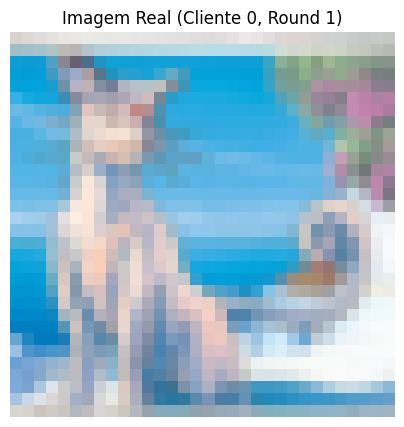

✓ Preparação para ataque DLG completa!


In [8]:
# from run import GLOBAL_GRADS, GLOBAL_INITIALS, GLOBAL_WEIGHTS, GLOBAL_METADATA
import matplotlib.pyplot as plt

print("="*60)
print("SELEÇÃO DE ALVO PARA ATAQUE DLG (FOCADO NA RODADA 1)")
print("="*60)

if not GLOBAL_GRADS:
    print("❌ Erro: Nenhum gradiente interceptado!")
else:
    # Todas as chaves disponíveis
    all_keys = list(GLOBAL_GRADS.keys())

    # Filtrar rodada 1
    vulnerable_targets = [k for k in all_keys if k[0] == 1]

    if vulnerable_targets:
        TARGET_ROUND, TARGET_CLIENT = vulnerable_targets[0]
        print("✓ Alvo vulnerável encontrado na Rodada 1!")
    else:
        print("⚠️ Nenhum alvo da rodada 1 — pegando aleatório")
        TARGET_ROUND, TARGET_CLIENT = random.choice(all_keys)

    print(f"\n🎯 Alvo selecionado:")
    print(f"   - Cliente: {TARGET_CLIENT}")
    print(f"   - Rodada: {TARGET_ROUND}")

    # Gradientes interceptados
    intercepted_gradients = GLOBAL_GRADS[(TARGET_ROUND, TARGET_CLIENT)]
    intercepted_metadata = GLOBAL_METADATA.get((TARGET_ROUND, TARGET_CLIENT))

    print(f"\n📊 Gradientes interceptados: {len(intercepted_gradients)} tensores")

    # converter para tensor
    def to_tensor_float(g):
        if isinstance(g, np.ndarray):
            return torch.from_numpy(g).float()
        return g.float()

    attack_gradients = [to_tensor_float(g) for g in intercepted_gradients if g is not None]

    print("   - Status: sem quantização (baseline)")

    # Pesos iniciais
    intercepted_initial = GLOBAL_INITIALS[(TARGET_ROUND, TARGET_CLIENT)]

    print(f"\n📦 Pesos iniciais interceptados: {len(intercepted_initial)} tensores")

    # Criar cliente alvo
    target_client = ClienteComQuantizacao(
        TARGET_CLIENT,
        NIID,
        NCLIENTS,
        DIRICHLET_ALPHA,
        quantizer=quantizer if ENABLE_QUANTIZATION else None,
    )

    img_tensor, label_idx = target_client.train_dataset[0]

    real_image = img_tensor.unsqueeze(0)
    real_label = torch.tensor([label_idx])

    print(f"\n✓ Imagem real carregada:")
    print(f"   - Shape: {real_image.shape}")
    print(f"   - Label: {real_label.item()}")

    # Visualizar imagem
    plt.figure(figsize=(5, 5))
    img_display = real_image[0].permute(1, 2, 0).numpy()
    img_display = (img_display * 0.5) + 0.5
    img_display = np.clip(img_display, 0, 1)
    plt.imshow(img_display)
    plt.title(f"Imagem Real (Cliente {TARGET_CLIENT}, Round {TARGET_ROUND})")
    plt.axis("off")
    plt.show()

    print("="*60)
    print("✓ Preparação para ataque DLG completa!")
    print("="*60)


In [11]:
# ===============================================================
# 🔍 VALIDAÇÃO DE GRADIENTES — VERSÃO FINAL COMPATÍVEL
# ===============================================================
import random
import matplotlib.pyplot as plt
import logging
import torch
import numpy as np
import utils

logging.basicConfig(level=logging.ERROR)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"{'='*60}")
print("🔍 VALIDAÇÃO DE GRADIENTES (usando pesos e gradientes interceptados)")
print(f"{'='*60}")

# ===============================================================
# 1) Obter gradientes/pesos dos globais criados na simulação
# ===============================================================
GLOBAL_GRADS = globals().get("GLOBAL_GRADS", {})
GLOBAL_INITIALS = globals().get("GLOBAL_INITIALS", {})
GLOBAL_METADATA = globals().get("GLOBAL_METADATA", {})

if not GLOBAL_GRADS:
    raise ValueError("Nenhum gradiente interceptado encontrado em GLOBAL_GRADS. Rode a simulação primeiro!")

# Escolher rodadas vulneráveis (1)
keys = list(GLOBAL_GRADS.keys())
keys_r1 = [k for k in keys if k[0] == 1]

if not keys_r1:
    print("⚠️ AVISO: Não encontrei dados da Rodada 1 (SGD, batch=1). Selecionando chave aleatória.")
    keys_r1 = keys

TARGET_ROUND, TARGET_CLIENT = keys_r1[0]
print(f"🎯 Alvo selecionado: cliente={TARGET_CLIENT} | rodada={TARGET_ROUND}")

# Carregar gradientes e pesos iniciais
intercepted_gradients = GLOBAL_GRADS[(TARGET_ROUND, TARGET_CLIENT)]
intercepted_initial = GLOBAL_INITIALS[(TARGET_ROUND, TARGET_CLIENT)]

if intercepted_gradients is None or intercepted_initial is None:
    raise ValueError("Dados interceptados incompletos para esse cliente.")

print(f"\n📊 Total de gradientes interceptados: {len(intercepted_gradients)}")


# ===============================================================
# 2) Converter gradientes numpy -> torch
# ===============================================================

def to_tensor(g):
    if g is None:
        return None
    if isinstance(g, torch.Tensor):
        return g.float().to(device)
    if isinstance(g, np.ndarray):
        return torch.from_numpy(g).float().to(device)
    return torch.tensor(g, dtype=torch.float32).to(device)

attack_gradients = [to_tensor(g) for g in intercepted_gradients]
print(f"✓ Gradientes convertidos para tensores CUDA/CPU")


# ===============================================================
# 3) Criar o cliente temporário e pegar a imagem real índice 0
# ===============================================================
PATH = "/home/nicolas/Documentos/topicos_sistemas_distribuidos/trabalho/DATASETS/Pokedex_v14"

temp_client = ClienteComQuantizacao(
    TARGET_CLIENT,
    NIID,
    NCLIENTS,
    DIRICHLET_ALPHA,
    dataset_path=PATH,
    quantizer=None
)

img_tensor_norm, label_idx = temp_client.train_dataset[0]
real_image_normalized = img_tensor_norm.unsqueeze(0).to(device)
real_label = torch.tensor([label_idx]).to(device)

print(f"\n✓ Imagem real carregada: shape={real_image_normalized.shape}, label={real_label.item()}")


# ===============================================================
# 4) Reconstruir modelo usando exatamente o mesmo factory
# ===============================================================
dataset_for_model = temp_client.full_dataset
modelo = utils.cria_modelo("pokemon", dataset=dataset_for_model).to(device)
modelo.eval()

print("✓ Modelo reconstruído via utils.cria_modelo (compatível com os clientes).")


# ===============================================================
# 5) Converter pesos iniciais interceptados -> tensores
# ===============================================================
weights_load = []
for w in intercepted_initial:
    if isinstance(w, np.ndarray):
        weights_load.append(torch.from_numpy(w).float().to(device))
    elif isinstance(w, torch.Tensor):
        weights_load.append(w.float().to(device))
    else:
        weights_load.append(torch.tensor(w, dtype=torch.float32).to(device))

# Mostrar shapes esperados e recebidos
print("\n=== Comparando shapes de pesos ===")
state_keys = list(modelo.state_dict().keys())
state_shapes = [tuple(v.shape) for v in modelo.state_dict().values()]
saved_shapes = [tuple(w.shape) for w in weights_load]

for k, a, b in zip(state_keys, state_shapes, saved_shapes):
    print(f"{k:35s}  model={a}  saved={b}")
    if a != b:
        raise ValueError(f"ERRO: Shape incompatível em {k}: esperado {a}, recebido {b}")

print("✓ Todos os shapes são compatíveis!")


# ===============================================================
# 6) Carregar pesos no modelo
# ===============================================================
sd = modelo.state_dict()
new_sd = {}

for (k, v), w in zip(sd.items(), weights_load):
    new_sd[k] = w

modelo.load_state_dict(new_sd)
print("✓ Pesos carregados com sucesso.")


# ===============================================================
# 7) Calcular gradientes locais usando one-hot + cross entropy
# ===============================================================
print("\n🧮 Recalculando gradientes locais...")

label_onehot = utils.label_to_onehot(real_label, num_classes=len(temp_client.full_dataset.classes))

output = modelo(real_image_normalized)
loss = utils.cross_entropy_for_onehot(output, label_onehot)

grads_calculated = torch.autograd.grad(loss, modelo.parameters())


# ===============================================================
# 8) Comparar gradientes
# ===============================================================
print("\n⚖️ Comparando gradientes...")

diffs = []
for g_int, g_calc in zip(attack_gradients, grads_calculated):
    d = torch.norm(g_int - g_calc).item()
    n = torch.norm(g_calc).item()
    diffs.append(d / (n + 1e-8))

avg = float(np.mean(diffs))
print(f"📉 Erro relativo médio = {avg:.6f}")

if avg < 0.001:
    print("✅ Gradientes idênticos — ataque DLG pode rodar com precisão máxima.")
elif avg < 0.1:
    print("⚠️ Pequenas diferenças — ainda é possível reconstruir imagem.")
else:
    print("❌ Erros grandes — pesos ou imagem não correspondem.")


print(f"{'='*60}")


🔍 VALIDAÇÃO DE GRADIENTES (usando pesos e gradientes interceptados)
🎯 Alvo selecionado: cliente=0 | rodada=1

📊 Total de gradientes interceptados: 10
✓ Gradientes convertidos para tensores CUDA/CPU
[Cliente 0] Device: cuda

✓ Imagem real carregada: shape=torch.Size([1, 3, 32, 32]), label=0
✓ Modelo reconstruído via utils.cria_modelo (compatível com os clientes).

=== Comparando shapes de pesos ===
body.0.weight                        model=(32, 3, 5, 5)  saved=(32, 3, 5, 5)
body.0.bias                          model=(32,)  saved=(32,)
body.2.weight                        model=(64, 32, 5, 5)  saved=(64, 32, 5, 5)
body.2.bias                          model=(64,)  saved=(64,)
body.4.weight                        model=(64, 64, 5, 5)  saved=(64, 64, 5, 5)
body.4.bias                          model=(64,)  saved=(64,)
body.6.weight                        model=(64, 64, 5, 5)  saved=(64, 64, 5, 5)
body.6.bias                          model=(64,)  saved=(64,)
fc.0.weight                      

## 3. Implementar Ataque DLG

EXECUÇÃO DO ATAQUE iDLG (Corrigido para nova arquitetura)

🧠 Inferindo label pelo iDLG...
✓ Label inferido via iDLG: 0
✓ Label real:               0

🚀 Iniciando Ataque com 3 restarts...

🔄 Tentativa 1: Gaussian


100%|██████████| 300/300 [01:40<00:00,  2.98it/s, loss=2.24]


   🏆 Melhor resultado atualizado: 2.240429

🔄 Tentativa 2: Zeros


100%|██████████| 300/300 [00:02<00:00, 113.53it/s, loss=1.9]


   🏆 Melhor resultado atualizado: 1.901196

🔄 Tentativa 3: Uniform[-0.5,0.5]


100%|██████████| 300/300 [01:42<00:00,  2.92it/s, loss=1.91]


✓ Ataque finalizado — melhor loss: 1.901196


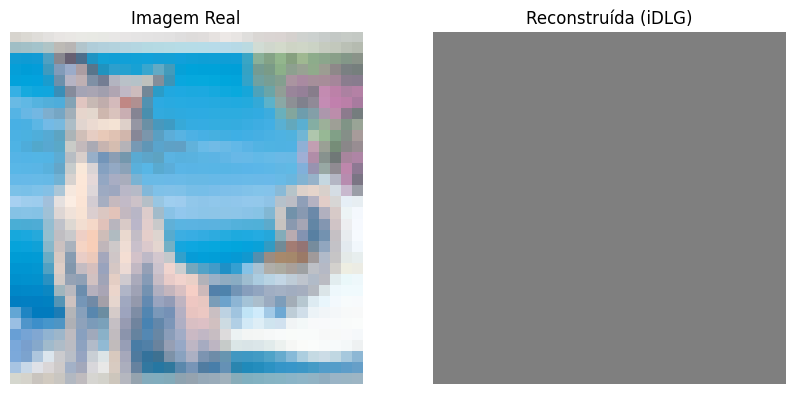


📈 Métricas:
   - MSE:  0.075789
   - PSNR: 11.20 dB
   - SSIM indisponível


In [13]:
# ===============================================================
# Ataque iDLG — Versão corrigida para nova arquitetura e globais
# ===============================================================
import torch
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import utils

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"{'='*60}")
print("EXECUÇÃO DO ATAQUE iDLG (Corrigido para nova arquitetura)")
print(f"{'='*60}")

# ===============================================================
# 1. VALIDAR ENTRADAS NECESSÁRIAS
# ===============================================================
vars_needed = ["modelo", "attack_gradients", "real_image_normalized", "real_label"]
for v in vars_needed:
    if v not in globals():
        raise ValueError(f"Variável necessária '{v}' não encontrada. Rode o bloco de validação primeiro!")

real_image = real_image_normalized  # renomeio para conveniência

# ===============================================================
# 2. INFERIR LABEL PELO GRADIENTE DA FC.bias
# ===============================================================
print("\n🧠 Inferindo label pelo iDLG...")

# O gradiente da última camada (bias) normalmente é o último tensor
fc_bias_grad = attack_gradients[-1].view(-1)

inferred_label = torch.argmin(fc_bias_grad).item()
print(f"✓ Label inferido via iDLG: {inferred_label}")
print(f"✓ Label real:               {real_label.item()}")

num_classes = len(fc_bias_grad)
label_onehot = utils.label_to_onehot(
    torch.tensor([inferred_label], device=device),
    num_classes=num_classes
)

# ===============================================================
# 3. FUNÇÃO DO ATAQUE (corrigida)
# ===============================================================
def run_ataque_with_restarts(modelo, target_onehot, target_grads,
                             num_iterations=300, n_restarts=3):

    best_loss = float('inf')
    best_image = None

    print(f"\n🚀 Iniciando Ataque com {n_restarts} restarts...")

    for attempt in range(n_restarts):

        if attempt == 0:
            dummy = torch.randn_like(real_image, device=device).requires_grad_(True)
            init_type = "Gaussian"
        elif attempt == 1:
            dummy = torch.zeros_like(real_image, device=device).requires_grad_(True)
            init_type = "Zeros"
        else:
            dummy = (torch.rand_like(real_image, device=device) - 0.5).requires_grad_(True)
            init_type = "Uniform[-0.5,0.5]"

        print(f"\n🔄 Tentativa {attempt+1}: {init_type}")

        optimizer = torch.optim.LBFGS([dummy], lr=0.05)

        pbar = tqdm(range(num_iterations))
        for _ in pbar:

            def closure():
                optimizer.zero_grad()

                out = modelo(dummy)
                loss_ce = utils.cross_entropy_for_onehot(out, target_onehot)

                dummy_grads = torch.autograd.grad(
                    loss_ce,
                    modelo.parameters(),
                    create_graph=False,
                    retain_graph=False
                )

                grad_diff = 0
                for g1, g2 in zip(dummy_grads, target_grads):
                    g2 = g2.to(device)
                    if g1.shape == g2.shape:
                        grad_diff += ((g1 - g2)**2).mean()

                # --- TV Loss com força maior ---
                tv = 1e-2 * (
                    torch.sum(torch.abs(dummy[:, :, :, :-1] - dummy[:, :, :, 1:])) +
                    torch.sum(torch.abs(dummy[:, :, :-1, :] - dummy[:, :, 1:, :]))
                )

                total = grad_diff + tv
                total.backward()
                return total

            loss_val = optimizer.step(closure)

            # --- Clipping anti-NaN ---
            with torch.no_grad():
                dummy.data.clamp_(-1, 1)

            if torch.isnan(dummy).any():
                print("⚠ NaN detectado → Reinicializando tentativa.")
                break

            pbar.set_postfix(loss=float(loss_val))

        # salvar melhor tentativa
        if float(loss_val) < best_loss:
            best_loss = float(loss_val)
            best_image = dummy.detach().cpu().clone()
            print(f"   🏆 Melhor resultado atualizado: {best_loss:.6f}")

    return best_image, best_loss


# ===============================================================
# 4. EXECUTAR ATAQUE
# ===============================================================
final_best_image, final_loss = run_ataque_with_restarts(
    modelo,
    label_onehot,
    attack_gradients,
    num_iterations=300,
    n_restarts=3
)

print(f"\n✓ Ataque finalizado — melhor loss: {final_loss:.6f}")

# ===============================================================
# 5. VISUALIZAÇÃO
# ===============================================================
def tensor_to_img_display(t):
    img = t.detach().cpu().squeeze().permute(1,2,0).numpy()
    img = (img * 0.5) + 0.5   # depende do dataset!
    img = np.clip(img, 0, 1)
    return img

img_real = tensor_to_img_display(real_image)
img_fake = tensor_to_img_display(final_best_image)

fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(img_real); axes[0].set_title("Imagem Real"); axes[0].axis("off")
axes[1].imshow(img_fake); axes[1].set_title("Reconstruída (iDLG)"); axes[1].axis("off")
plt.show()

# ===============================================================
# 6. MÉTRICAS
# ===============================================================
print("\n📈 Métricas:")

mse = np.mean((img_real - img_fake)**2)
print(f"   - MSE:  {mse:.6f}")

if mse > 1e-10:
    psnr = 10*np.log10(1.0/mse)
    print(f"   - PSNR: {psnr:.2f} dB")
else:
    print("   - PSNR: infinito")

try:
    from skimage.metrics import structural_similarity as ssim
    ssim_val = ssim(img_real, img_fake, channel_axis=2)
    print(f"   - SSIM: {ssim_val:.4f}")
except:
    print("   - SSIM indisponível")
